# Importing Libraries


In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Loading Data


In [ ]:
df = pd.read_csv("../data/interim/data_selected.csv")
df.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,0.11840,0.14710,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.4601,0.11890
1,M,20.57,17.77,0.08474,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.2750,0.08902
2,M,19.69,21.25,0.10960,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.3613,0.08758
3,M,11.42,20.38,0.14250,0.10520,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.6638,0.17300
4,M,20.29,14.34,0.10030,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.2364,0.07678


# Data Preparation


In [ ]:
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visual Checks


## Correlation Heatmap


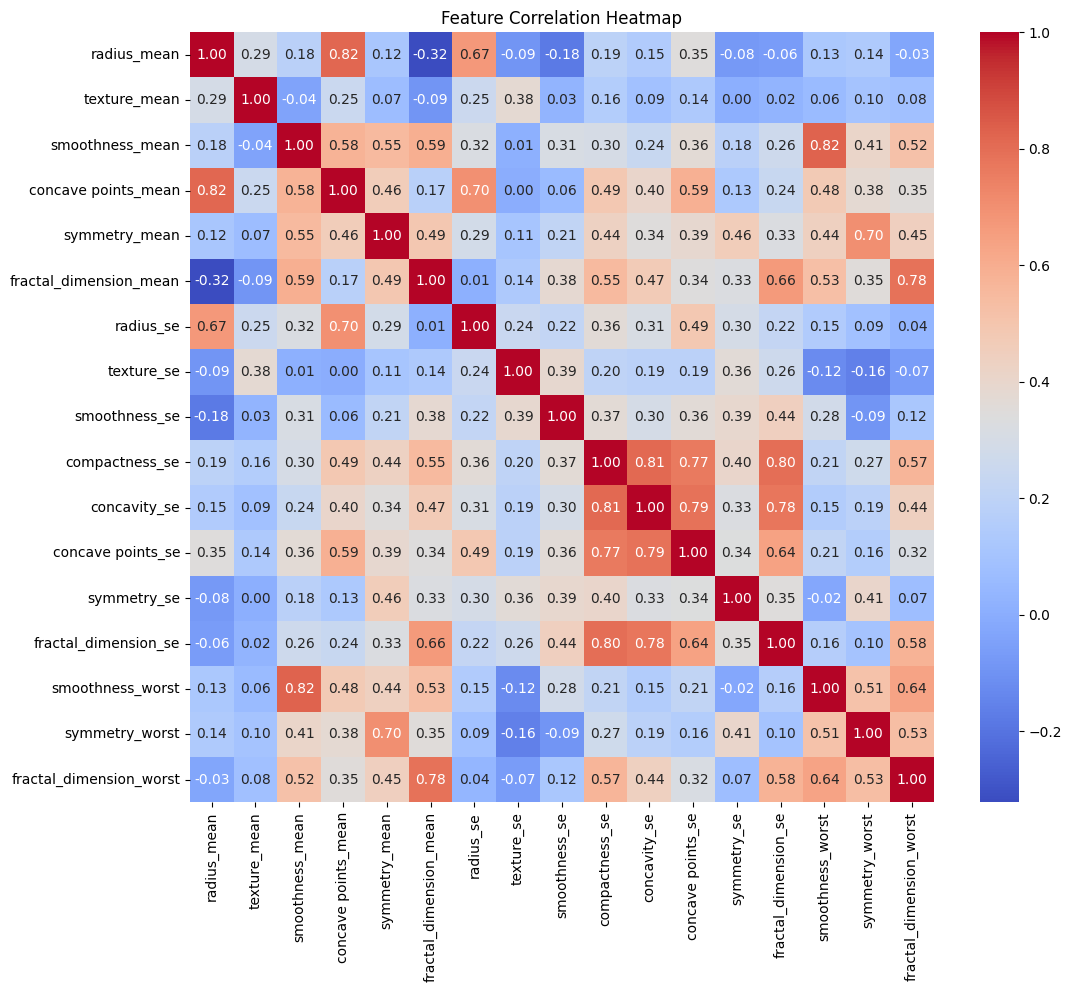

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    pd.DataFrame(X_train_scaled, columns=X.columns).corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
)
plt.title("Feature Correlation Heatmap")
plt.show()

Several features exhibit strong pairwise correlations (above 0.8), such as:

- `concave_points_mean` ↔ `radius_mean` (0.82)
- `smoothness_worst` ↔ `smoothness_mean` (0.82)
- `concavity_se` ↔ `compactness_se` (0.81)

This indicates redundancy among features, motivating the use of dimensionality reduction.


## Variance per feature


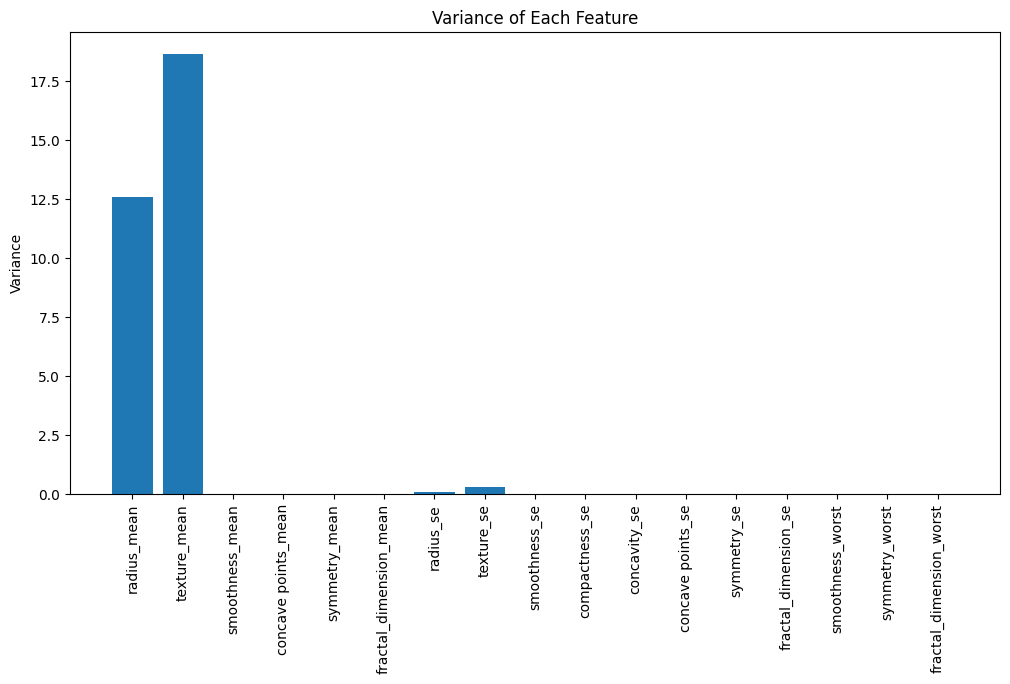

In [ ]:
variances = np.var(X_train, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(X.columns, variances)
plt.xticks(rotation=90)
plt.title("Variance of Each Feature")
plt.ylabel("Variance")
plt.show()

Although many features show minimal variance before scaling, this does not necessarily imply irrelevance. In the context of cell-level measurements, subtle differences in feature values can correspond to meaningful biological distinctions between benign and malignant samples.


# Principal Component Analysis (PCA)


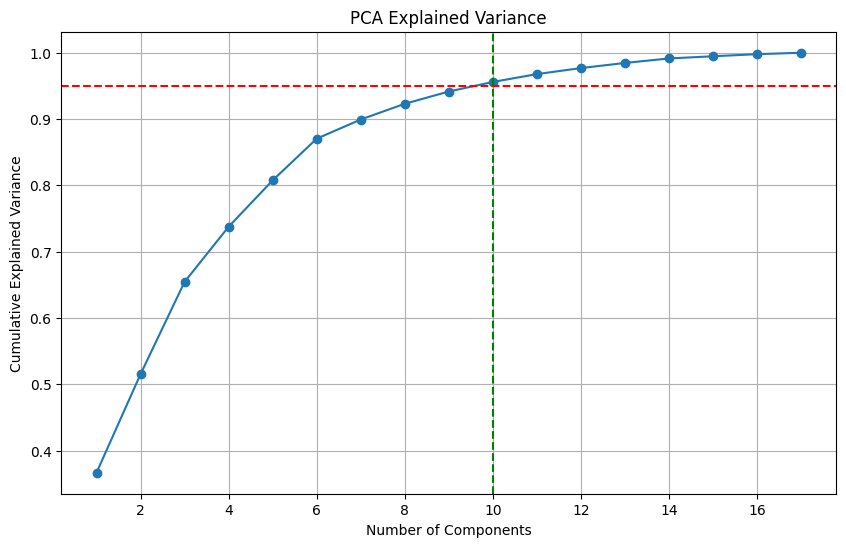

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker="o"
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.axhline(y=0.95, color="r", linestyle="--")
plt.axvline(
    x=np.argmax(np.cumsum(explained_variance) >= 0.95) + 1, color="g", linestyle="--"
)
plt.show()

We can see that 10 components is the minimum if we want to keep atleast 95% of explained variance.


In [ ]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 17
Reduced number of features after PCA: 10


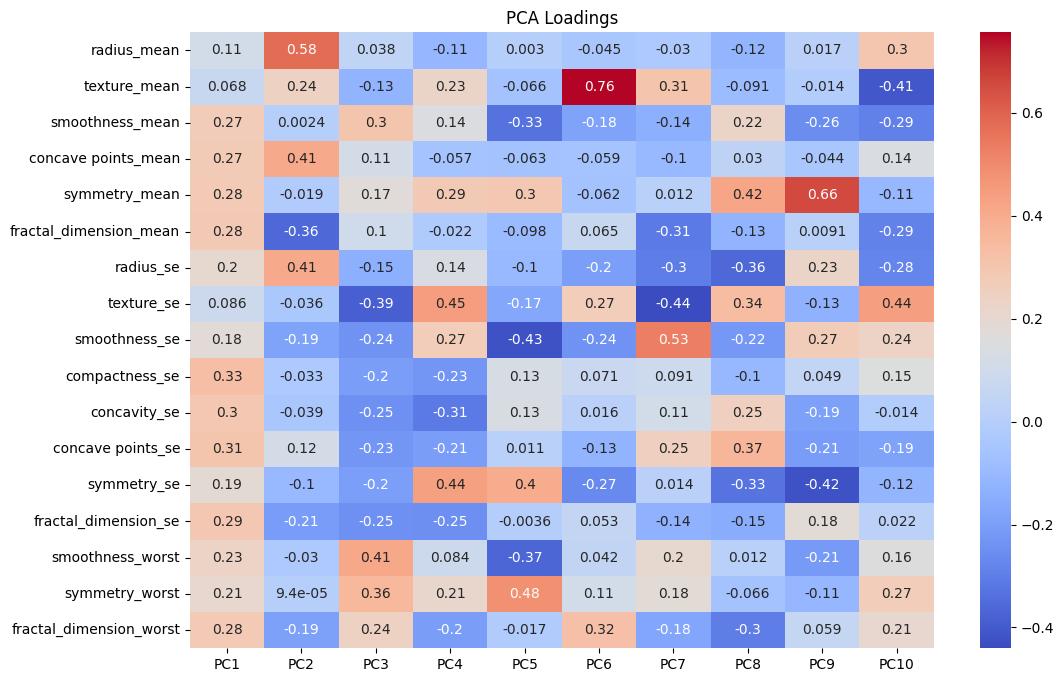

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T, columns=[f"PC{i+1}" for i in range(10)], index=X.columns
)
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap="coolwarm")
plt.title("PCA Loadings")
plt.show()

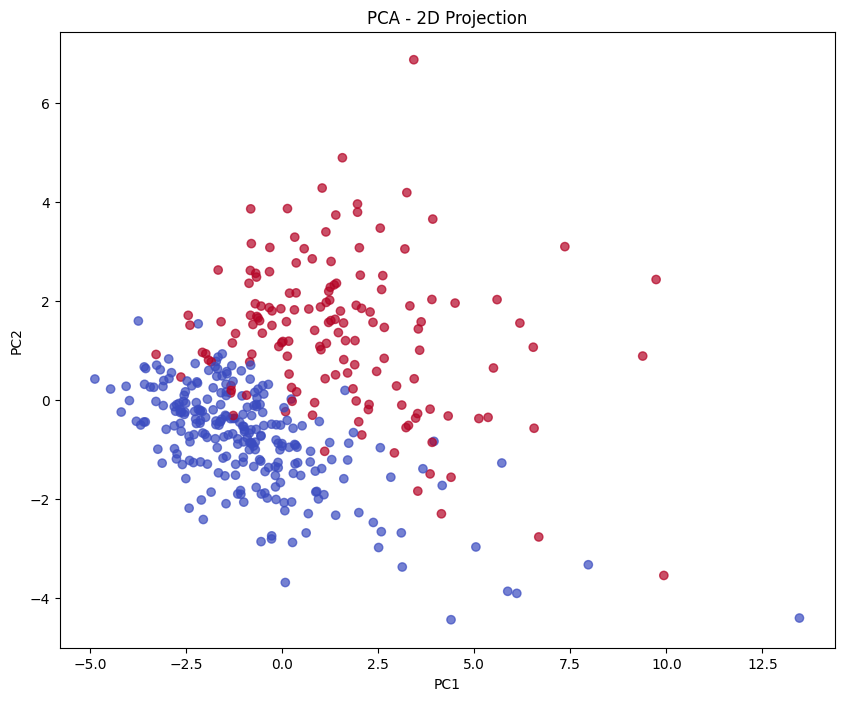

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train.map({"M": 1, "B": 0}),
    cmap="coolwarm",
    alpha=0.7,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - 2D Projection")
plt.show()

We can see a pretty good seperation with some overlap, which may be more clearly seperated with the other components.


# Linear Discriminant Analysis (LDA)


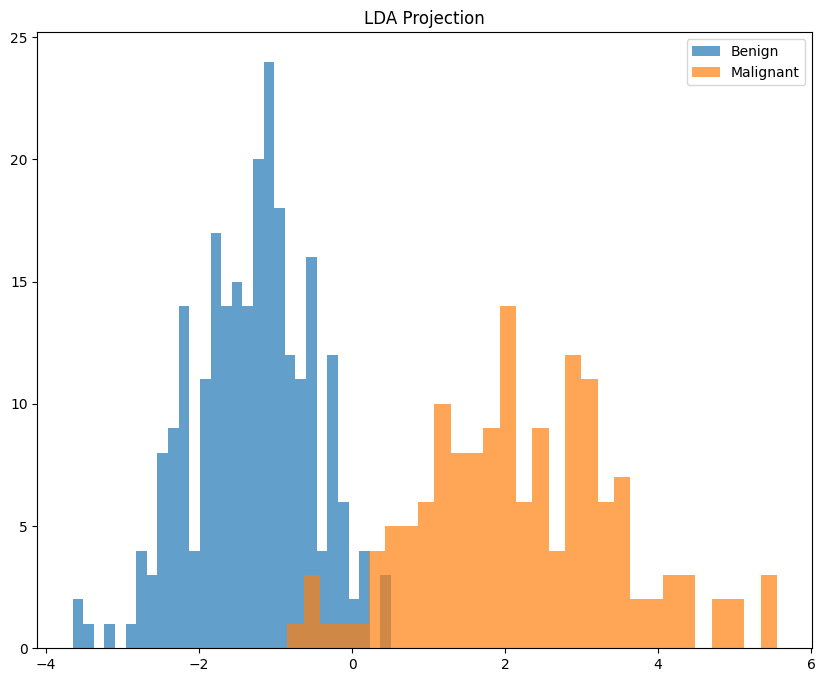

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

plt.figure(figsize=(10, 8))
plt.hist(X_train_lda[y_train == "B"], alpha=0.7, label="Benign", bins=30)
plt.hist(X_train_lda[y_train == "M"], alpha=0.7, label="Malignant", bins=30)
plt.legend()
plt.title("LDA Projection")
plt.show()

The LDA visualization indicates that the two cancer types can be linearly separated quite well. Since the PCA reduction retained 10 out of the original 17 features while capturing 95% of the total variance, we can be confident that these 10 principal components preserve most of the dataset’s informative structure.


# Saving Data


In [31]:
train_df = pd.DataFrame(
    X_train_pca, columns=[f"PC{i+1}" for i in range(pca.n_components)]
)
test_df = pd.DataFrame(
    X_test_pca, columns=[f"PC{i+1}" for i in range(pca.n_components)]
)

train_df["target"] = y_train.map({"M": 1, "B": 0}).values
test_df["target"] = y_test.map({"M": 1, "B": 0}).values

train_df["split"] = "train"
test_df["split"] = "test"

final_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
final_df.to_csv("../data/final/data_reduced.csv", index=False)